# Final Presentation


This notebook will walk you step by step through the process of using our trained rcnn model to detect litter from images pulled off google streets.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import math
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  


In [4]:
# What model to use
MODEL_NAME = 'litter_inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('kab_training', 'litter_detection_map.pbtxt')

NUM_CLASSES = 1

config = tf.ConfigProto()
config.gpu_options.force_gpu_compatible = True
config.gpu_options.per_process_gpu_memory_fraction = 1

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def rescale(im_width, im_height, image):
    aspectRatio = im_width / im_height
    new_width = ( 640 * aspectRatio )
    new_height = ( new_width / aspectRatio )
    image = image.resize((int(new_width), int(new_height)), resample=0)
    return image

# Detection

In [8]:
# The images to be tested are located in this directory
PATH_TO_TEST_IMAGES_DIR = 'final_presentation'

TEST_IMAGE_PATHS = []
for root, dirs, filenames in os.walk(PATH_TO_TEST_IMAGES_DIR):
    for f in filenames:
        file_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, f)
        TEST_IMAGE_PATHS.append(file_path)

# Size, in inches, of the output images.
IMAGE_SIZE = (16, 12)

# THRESHOLD
THRESHOLD = 0.65 # The minimum score threshold for showing detections. default = 0.5
MAX_BOXES = 30  # The maximum number of boxes to draw for detections. default = 30

In [9]:
def run_inference_for_single_image(image, graph, sess):
  # Get handles to input and output tensors
  ops = tf.get_default_graph().get_operations()
  all_tensor_names = {output.name for op in ops for output in op.outputs}
  tensor_dict = {}
    
  for key in [ 'num_detections', 'detection_boxes', 'detection_scores', 'detection_classes', 'detection_masks']:
    tensor_name = key + ':0'
    if tensor_name in all_tensor_names:
      tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
    
  if 'detection_masks' in tensor_dict:
    # The following processing is only for single image
    detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
    detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
    real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks( detection_masks, detection_boxes, image.shape[0], image.shape[1])
    detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
    # Follow the convention by adding back the batch dimension
    tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
    
  image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

  # Run inference
  output_dict = sess.run(tensor_dict,feed_dict={image_tensor: np.expand_dims(image, 0)})

  # all outputs are float32 numpy arrays, so convert types as appropriate
  output_dict['num_detections'] = int(output_dict['num_detections'][0])
  output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
  output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
  output_dict['detection_scores'] = output_dict['detection_scores'][0]
    
  if 'detection_masks' in output_dict:
    output_dict['detection_masks'] = output_dict['detection_masks'][0]
    
  return output_dict


// Running object detection algorithm
[0] Processed final_presentation/test12.jpg 	 time = 13.4613516330719
[1] Processed final_presentation/image14.jpg 	 time = 6.809965133666992
[2] Processed final_presentation/test20.jpg 	 time = 6.697587013244629
[3] Processed final_presentation/test23.jpg 	 time = 6.808588981628418


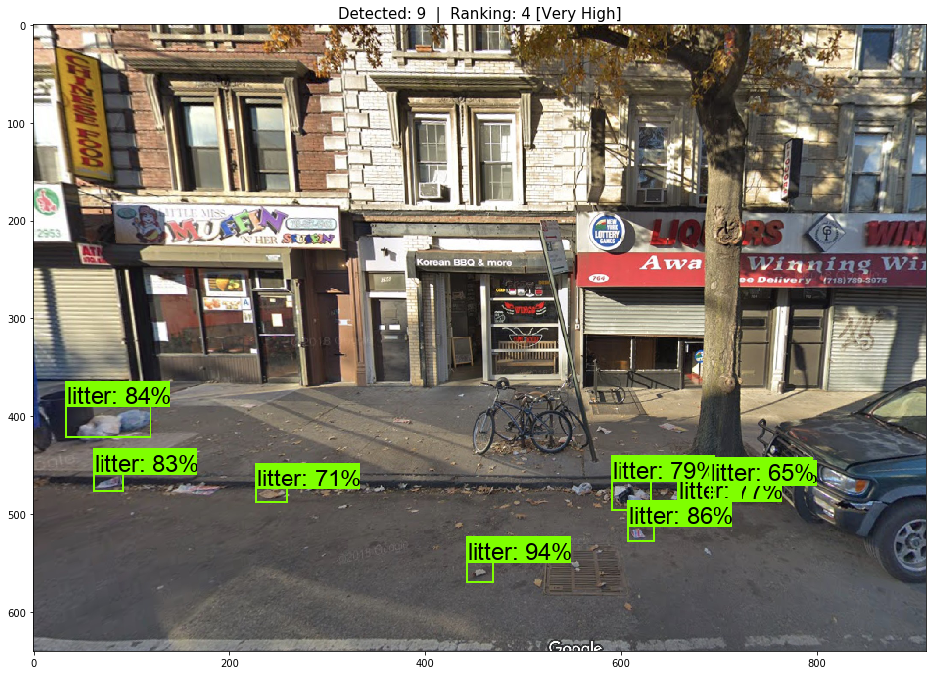

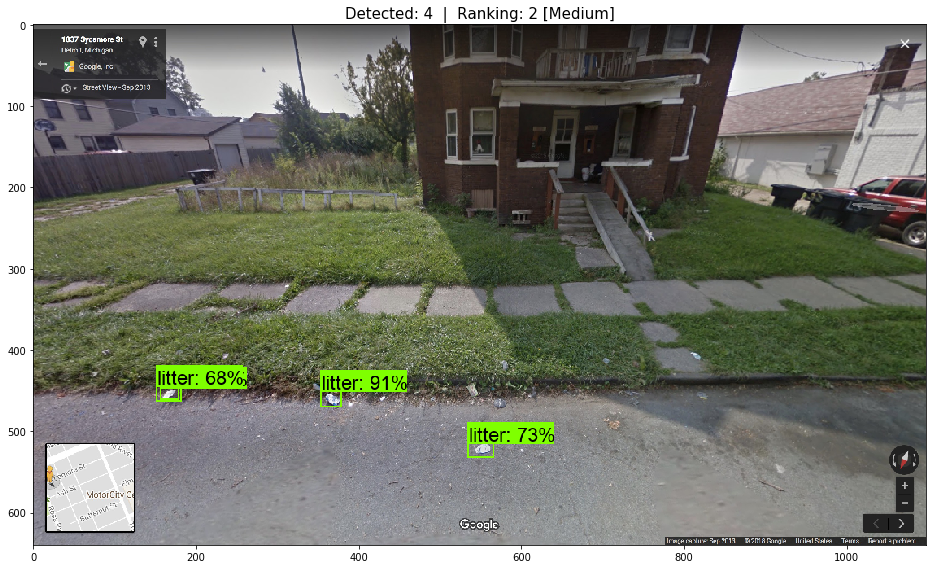

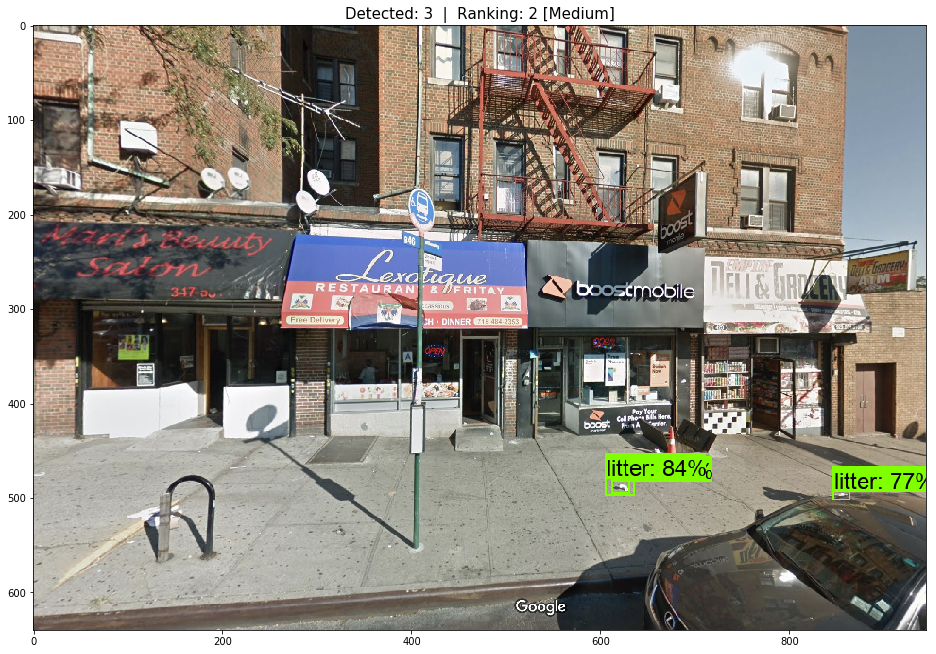

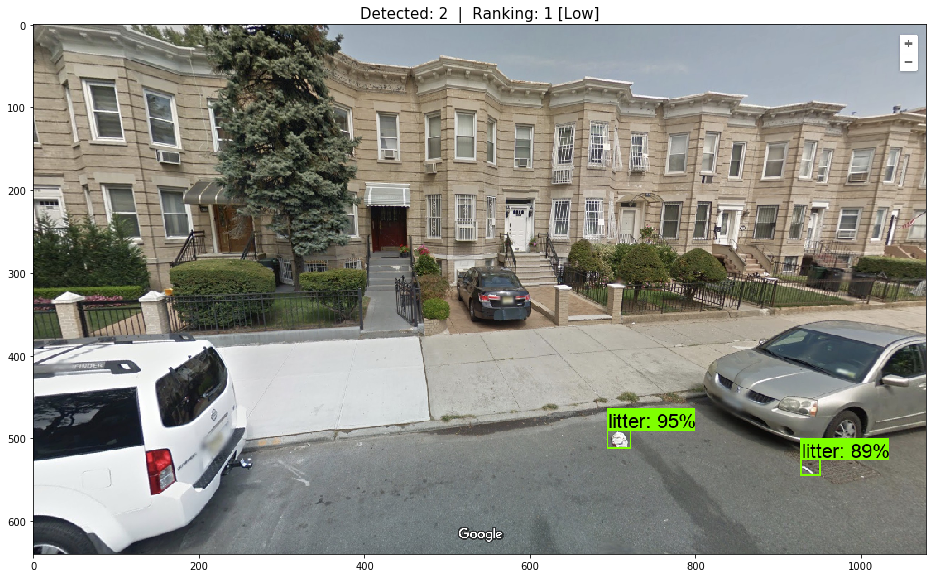

In [10]:
print('\n// Running object detection algorithm')

with detection_graph.as_default():
    sess = tf.Session(graph=detection_graph,config=config)
    with tf.device('/device:GPU:0'):
        for i, image_path in enumerate(TEST_IMAGE_PATHS):
            start = time.time()

            image = Image.open(image_path)
            im_width, im_height = image.size

            # rescale image if bigger than 640 x 640
            if (im_width > 640 or im_height > 640):
                image = rescale(im_width, im_height, image)

            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # Actual detection.
            output_dict = run_inference_for_single_image(image_np, detection_graph, sess)
            total = time.time() - start
    
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks'),
              use_normalized_coordinates=True,
              max_boxes_to_draw=MAX_BOXES,
              min_score_thresh=THRESHOLD,
              line_thickness=2)

            # Get the number of detections shown on image          
            count = len([i for i in output_dict['detection_scores'] if i >= THRESHOLD])

            # Determine the ranking
            rank_dict = {1: 'Low', 2:'Medium', 3:'High', 4:'Very High'}

            if count in range(0, 3):          # 0 - 2 objects [low]
              rank = 1
            elif count in range(3, 6):        # 3 - 5 objects [medium]
              rank = 2
            elif count in range(6, 9):        # 6 - 8 objects [high]
              rank = 3
            elif count >= 9:                  # 9 + objects [very high]
              rank = 4

            # display the image
            plt.figure(figsize=IMAGE_SIZE)
            plt.title("Detected: " + str(count) + "  |  Ranking: " + str(rank) + " [" + rank_dict[rank] + "]", fontsize=15)
            plt.imshow(image_np)
            
            print("[" + str(i) + "] Processed " + str(image_path) + " \t time = " + str(total))
